# Biodiversity Intactness Index for Phoenix, Arizona from 2017 to 2020

In this notebook, we will be taking a brief look at changes in the biodiversity intactness index (BII) for Phoenix, Arizona. This project was spurred by the recent increases in urbanization across the greater Phoenix area, resulting in major habitat loss that locaL species are reliant upon.

### A quick summary of the data:

The Biodiversity Intactness Index from Planetary Computer is generated by ImpactObservation and Vizzuality, and is an estimation of species abundance, richness, counts, and 'Compositional Similarity', which compares each sample ecosystem to an intact baseline. The methods utilized to estimate spatial biodiversity were developed in the paper “Global 100m Projections of Biodiversity Intactness for the years 2017-2020.”

This data used for modeling was sampled across 32,000 sites over 750 individual studies, and compiled into the PREDICTS database. Using this STAC collection, we can compare the Biodiversity Intactness Index for different locations or, in our case, the same location across different years.

To visualize our region of interest, we downloaded a shapefile of the counties in Arizona, from the US Census database. From this shapefile, we can isolate the geometry of Phoenix County.


### Loading in the Raster Data on Biodiversity Intactness 
- First, we will load in any necesary packages and load in the data from Microsoft, assigning it to a variable for the catalog

In [40]:
# Import necessary packages
import geopandas as gpd
import pandas as pd

import planetary_computer
import pystac_client

import os
import rioxarray as rioxr

from shapely.geometry import box

import contextily as ctx

import matplotlib.pyplot as plt
import matplotlib.colors as ListedColormap
from matplotlib.lines import Line2D

In [2]:
# Load in the data via the link and assign it to a catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [3]:
# Filter through the catalog for the BII information, and list the corresponding items
catalog.get_collections()
collections = list(catalog.get_collections()) # Turn generator into list

# Print the number of collections
print('Number of collections:', len(collections))

# Pull out the Biodiversity Index collection
BII_collection = catalog.get_child('io-biodiversity')
BII_collection

Number of collections: 124


<CollectionClient id=io-biodiversity>

In [4]:
# Create a boundary box for the Phoenix area
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

In [5]:
# Time range of interest defined
time_range = "2017-01-01/2020-01-01"

# Catalog search for the BII data, using our time range, and boundaries
search= catalog.search(
    collections= ['io-biodiversity'],
    bbox = bbox_of_interest,
    datetime= time_range,
)
search

In [6]:
# Get items from search
items = search.item_collection()

# Determine number of items in search
print(f'There are {len(items)} items in the search.')

There are 4 items in the search.


In [7]:
# Check the first item in the items
item= items[0]
item

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>

In [8]:
# Figure out which years correspond to which bands
item_names = {item.id : item for item in search.items()}
list(item_names)

['bii_2020_34.74464974521749_-115.38597824385106_cog',
 'bii_2019_34.74464974521749_-115.38597824385106_cog',
 'bii_2018_34.74464974521749_-115.38597824385106_cog',
 'bii_2017_34.74464974521749_-115.38597824385106_cog']

In [9]:
# Select items 1 and 4 (or 0 and 3) for the 2017 and 2020 data
BII_2017 = items[3]
BII_2020 = items[0]

### Creating the Boundary of the Phoenix Area from the US Census Subdivision shapefiles

In [10]:
# Creating a filepath to the Phoenix_Boundary.shp file, and reading it in using geopandas
fp= os.path.join('data', 'tl_2023_04_cousub.shp')
Arizona_Boundary= gpd.read_file(fp)

Arizona_Boundary.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231050070,44656143,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


In [11]:
# A brief look into the Arizona_Boundary data to find how to filter
Arizona_Boundary.NAME.unique()

array(['Flagstaff', 'Kaibab Plateau', 'Hualapai', 'Nogales', 'Patagonia',
       'Hopi', 'Tuba City', 'Clifton', 'Duncan', 'Chandler', 'Phoenix',
       'Tonto National Forest', 'Gila Bend', 'Wickenburg', 'Deer Valley',
       'Buckeye', 'St. Johns', 'Salt River', 'Tucson', 'Arivaca',
       'Indian Wells', 'Winslow-Holbrook', 'Snowflake', 'Kayenta',
       'Lake Havasu City', 'Fort Apache', 'Bisbee', 'Bowie', 'Willcox',
       'North Mohave', 'Kingman', 'Bullhead City', 'Congress',
       'Mingus Mountain', 'Florence', 'North Pinal', 'San Manuel', 'Eloy',
       'Chinle', 'Sweetwater', 'Fort Defiance', 'Dennehotso', 'Puerco',
       'Ash Fork', 'Cordes Lakes-Mayer', 'Camp Verde-Sedona', 'Prescott',
       'Piñon', 'Payson', 'Winkelman', 'Globe-Miami', 'Tonto Basin',
       'Gila River', 'Casa Grande', 'Maricopa-Stanfield',
       "Tohono O'odham Nation", 'Coolidge', 'Ajo', 'Marana', 'Somerton',
       'Bonita-Klondyke', 'Eagar-Springerville', 'San Carlos',
       'Havasupai', 'William

In [12]:
# Now Filter using the NAME column for the boundaries of Phoenix
Phoenix_Boundary = Arizona_Boundary[Arizona_Boundary.NAME == "Phoenix"]

# Find the crs of the Phoenix_Boundary
Phoenix_Boundary.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

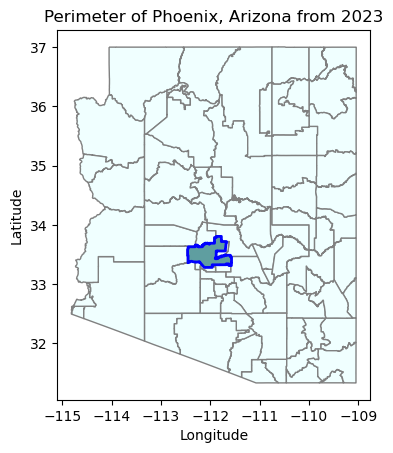

In [13]:
# Visualizing the state of Arizona with the Phoenix border emphasized
fig, ax = plt.subplots()

Arizona_Boundary.plot(ax=ax,
                     facecolor= "azure",
                     edgecolor= "grey")
Phoenix_Boundary.plot(ax=ax,
                 facecolor= "cadetblue",
                 edgecolor= 'blue',
                linewidth=2,
                label= 'Phoenix Boundary')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Perimeter of Phoenix, Arizona from 2023")
plt.show()

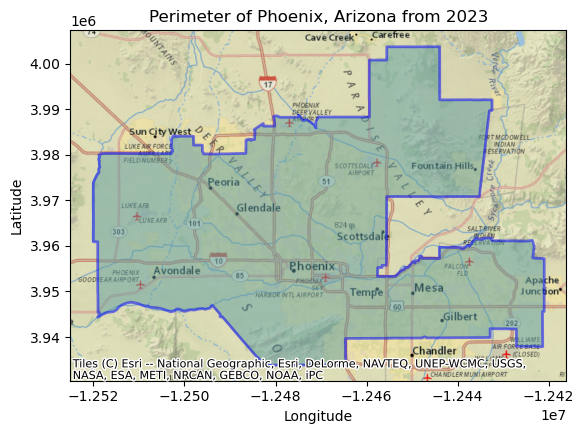

In [14]:
# Visualizing the Phoenix county border with an appropriate basemap
fig, ax = plt.subplots()

Phoenix_Boundary.to_crs(epsg= 3857).plot(ax=ax,
                 facecolor= "cadetblue",
                alpha= 0.5,
                 edgecolor= 'blue',
                linewidth=2,
                label= 'Phoenix Boundary')
ctx.add_basemap(ax=ax, 
               source= ctx.providers.Esri.NatGeoWorldMap)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Perimeter of Phoenix, Arizona from 2023")
plt.show()

### 2017 and 2020 Biodiversity Analysis

In [15]:
# Access raster data from item
BII_2017 = rioxr.open_rasterio(BII_2017.assets['data'].href)
BII_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [16]:
# Access raster data from item
BII_2020 = rioxr.open_rasterio(BII_2020.assets['data'].href)
BII_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [17]:
# Remove length 1 dimension (band)
BII_2017 = BII_2017.squeeze().drop_vars('band')
BII_2020 = BII_2020.squeeze().drop_vars('band')

In [18]:
# Match the crs from the Phoenix_Boundary and the BII_2017 data
Phoenix_Transform = Phoenix_Boundary.to_crs(BII_2017.rio.crs)

assert BII_2017.rio.crs == Phoenix_Transform.crs
assert BII_2017.rio.crs == BII_2020.rio.crs

In [19]:
# Clip the rasters to the extent of the Phoenix data
BII_2017_clip = (BII_2017.rio.clip_box(*Phoenix_Transform.total_bounds)
                 .rio.clip(Phoenix_Transform.geometry))

BII_2020_clip = (BII_2020.rio.clip_box(*Phoenix_Transform.total_bounds)
                         .rio.clip(Phoenix_Transform.geometry))

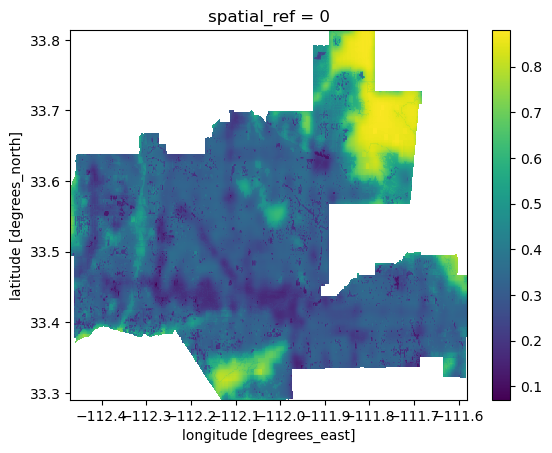

In [23]:
# Plot the data and compare the changes in Biodiversity Intactness
# The 2017 raster plotted
BII_2017_clip.plot()

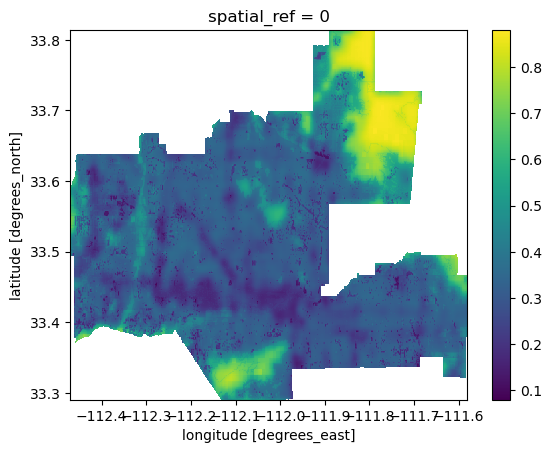

In [25]:
# The 2020 raster plotted
BII_2020_clip.plot()

### Find the Percent Area of Phoenix that has  BII of at least 0.75 from 2017 to 2020

In [26]:
# Filter to area with a BII greater than or equal to 0.75
BII_Area_2017 = (BII_2017_clip >= 0.75).astype(int)
BII_Area_2020 = (BII_2020_clip >= 0.75).astype(int)

#### 2017 Area of at least 0.75 BII

- Michelle Yiv and Bailey Jorgensesn provided assistance in developing the code for this section

In [28]:
# Find total number of pixels
total_2017 = BII_2017_clip.count().item()

# Find pixels with bii > 0.75
values_2017 = BII_Area_2017.sum().item() 

# Calculate percentage (part/whole)
pct_2017 = round((values_2017/total_2017) * 100, 2)

print("The percentage of Phoenix subdivision with a BII >= 0.75 in 2017 is", round(pct_2017, 2), "%")

The percentage of Phoenix subdivision with a BII >= 0.75 in 2017 is 7.13 %


#### 2020 Area of at least 0.75 BII

In [29]:
# Find total number of pixels
total_2020 = BII_2020_clip.count().item()

# Find pixels with bii > 0.75
values_2020 = BII_Area_2020.sum().item() 

# Calculate percentage (part/whole)
pct_2020 = (values_2020 / total_2020) * 100

print("The percentage of Phoenix subdivision with a BII >= 0.75 in 2020 is", round(pct_2020, 2), "%")

The percentage of Phoenix subdivision with a BII >= 0.75 in 2020 is 6.49 %


#### Calculate and visualize the difference in area from 2017 to 2020 that fits criteria

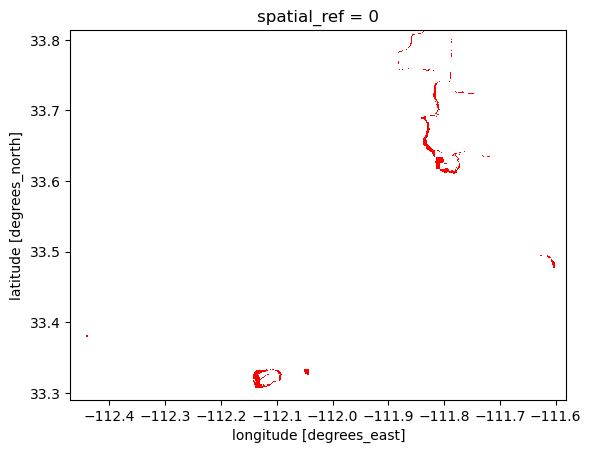

In [47]:
# Calculate loss from 2017 to 2020
Area_Diff = BII_Area_2017 - BII_Area_2020

# BII >0.75 in 2017 set to 1 to visualize data as boolean values
BII_loss = Area_Diff == 1

# Convert to integer for plotting purposes
BII_loss = BII_loss.astype(int)

# Make dictionary of colors
colors = {
    0: "none",        # No Data
    1: "red",         # Bii loss 
}
    
# Create a ListedColormap
cmap = ListedColormap.ListedColormap([colors[key] for key in sorted(colors.keys())])

# View updated inital plot
BII_loss.plot(cmap = cmap, add_colorbar = False)  

#### Create our final map of the Phoenix area, that shows the difference in BII greater or equal to 0.75 from 2017-2020

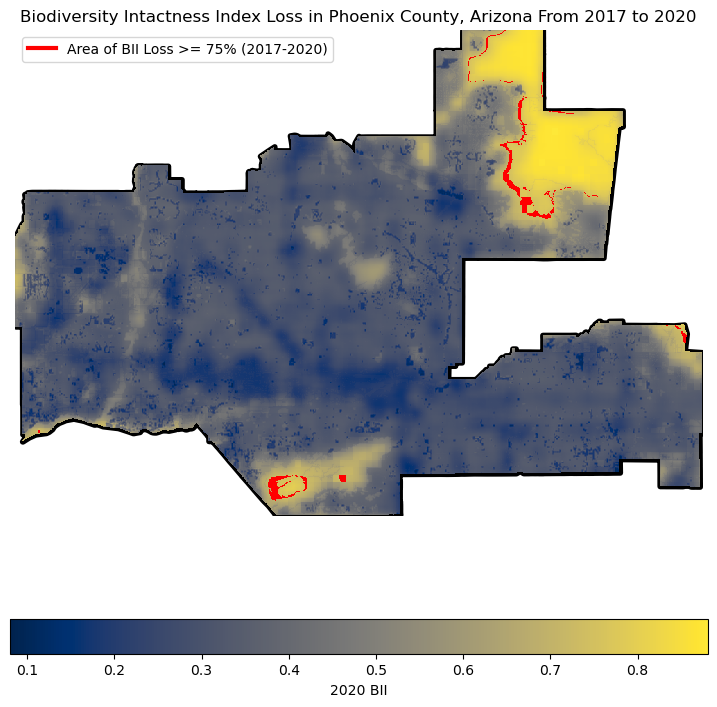

In [48]:
# Plotting the BII_loss variable over our map from earlier
# Initialize plot
fig, ax = plt.subplots(figsize= (9,9))

# Add Phoenix, AZ basemap 
Phoenix_Boundary.plot(ax=ax,
       edgecolor = 'black',
       linewidth = 4)

# Add 2020 biodiversity as base layer
BII_2020_clip.plot(ax = ax,
                   cmap= 'cividis',
                  cbar_kwargs = {"location": "bottom",
                                 "label": "2020 BII"})
# Add BII difference (from above)
BII_loss.plot(ax = ax,
              cmap = cmap, 
              add_colorbar = False)  

# Add legend
custom_legend = Line2D([0], [0], 
                       color='red', 
                       lw=3, 
                       label='Area of BII Loss >= 75% (2017-2020)') 

# Position the legend
ax.legend(handles=[custom_legend], loc='upper left', fontsize=10)

# Set title
ax.set_title("Biodiversity Intactness Index Loss in Phoenix County, Arizona From 2017 to 2020")

# Turn off axis
ax.set_axis_off()

plt.show()